# Ex1

Santiago Benites 54392

João Ferreira 55312

# Imports

In [55]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap
import lime
import lime.lime_tabular
from IPython.core.display import display, HTML

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display


# Load Dataset

In [56]:
(X_data,y_data) = load_breast_cancer(as_frame = True,return_X_y=True)

data = load_breast_cancer()
feature_names_original = data["feature_names"]
target_names_original = data["target_names"]

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=22)

In [57]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)

print(f"RF train accuracy: {clf.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {clf.score(X_test, y_test):.3f}")

RF train accuracy: 0.960
RF test accuracy: 0.947


## i) Explain the results obtained by this classifier by considering the Mean Decrease in Impurity (MDI).

As we can see from the graph below, we can see that the different features used to train the Random Forest Classifier don't have the same importance according to MDI.
Using the values presented bellow we can deduce that the CLF will be more influenced by higher ranked variables than lower ranked, this leads to the results above for accuracy.


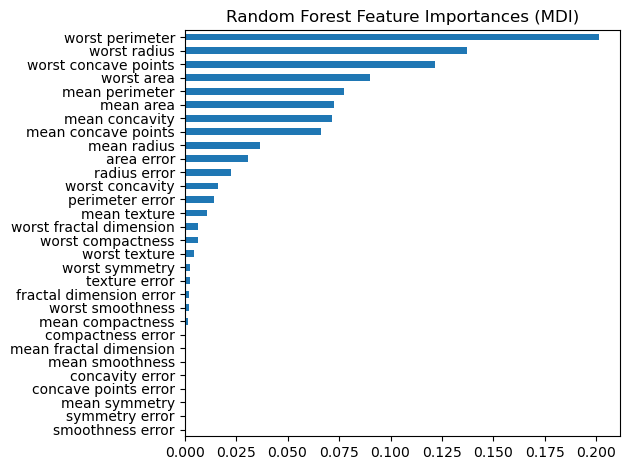

In [58]:
feature_names = clf.feature_names_in_

mdi_importances = pd.Series(
    clf.feature_importances_, index=feature_names
).sort_values(ascending=True)



ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()



## ii) Now consider the Permutation Feature Importance to explain the results obtained. In this case, compute and compare the results for the train and test sets.

As we can see in the following graphs there exists substantial difference between both the box and bar plots made from the test data and train data.
In the test data the variance of the data is substantially bigger than its train counterpart, this could be easily predicted considering it is considered bad practice to evaluate data using the train data.
All things considered it is interesting that the general trend of which features are more important stays the same between both training and test data.
All things considered, the results appear to be similar to the ones we received before and present a good confirmation of our results.

In [59]:
result = permutation_importance(
    clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances_test = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_data.columns[sorted_importances_idx],
)

result = permutation_importance(
    clf, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances_train = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_data.columns[sorted_importances_idx],
)

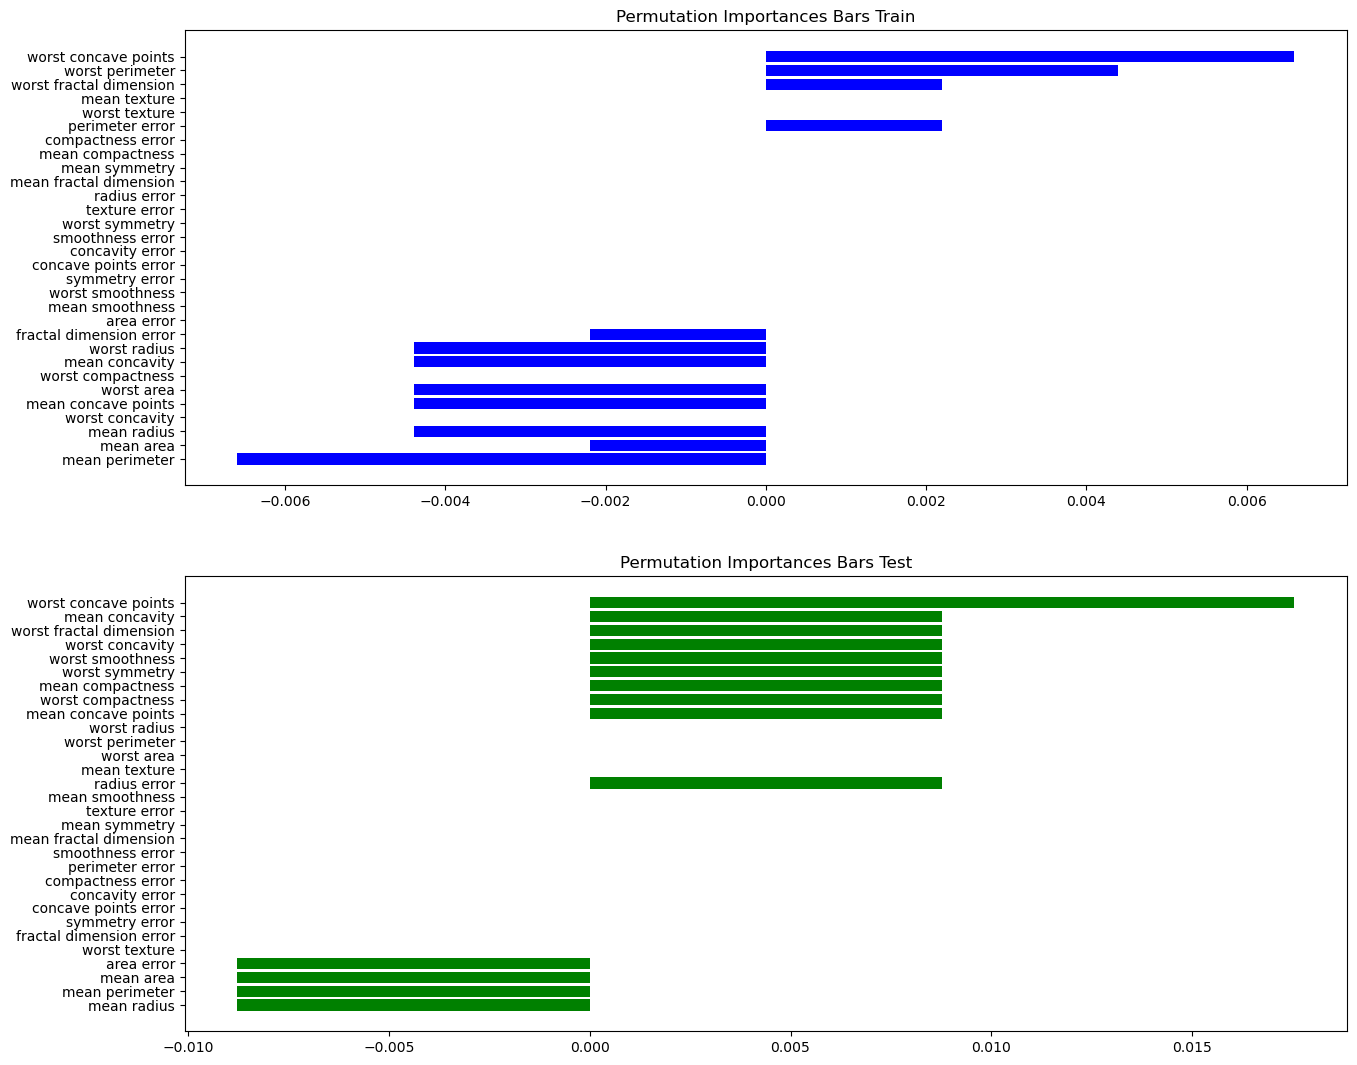

In [60]:
fig, (ax1, ax2) = plt.subplots(2,figsize=(15, 13))
ax1.barh(importances_train.columns, importances_train.values[0],color="blue")
ax1.set_title("Permutation Importances Bars Train")
ax2.barh(importances_test.columns, importances_test.values[0],color='green')
ax2.set_title("Permutation Importances Bars Test")
plt.show()

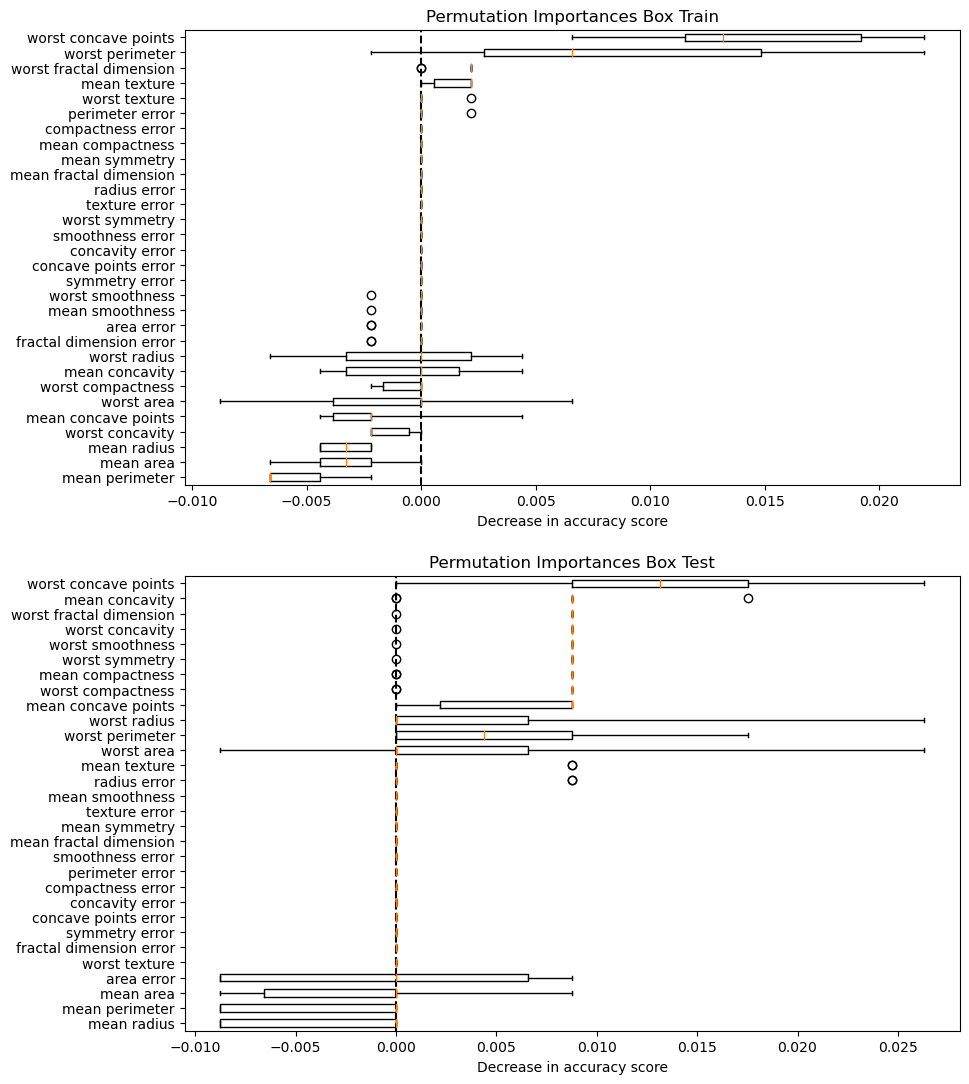

In [61]:
fig, (ax1, ax2) = plt.subplots(2,figsize=(10, 13))

ax1.boxplot(importances_train, vert=False, whis=10)
ax1.set_title("Permutation Importances Box Train")
ax1.axvline(x=0, color="k", linestyle="--")
ax1.set_xlabel("Decrease in accuracy score")
ax1.set_yticklabels(importances_train.columns)

ax2.boxplot(importances_test, vert=False, whis=10)
ax2.set_title("Permutation Importances Box Test")
ax2.axvline(x=0, color="k", linestyle="--")
ax2.set_xlabel("Decrease in accuracy score")
ax2.set_yticklabels(importances_test.columns)

plt.show()

## iii) Can you observe significant differences in the explanatory power in the two previous approaches in the training set? (see this link for more information).

From the past 2 implementation we can come to some conclusion regarding which are the most crucial features in the data set

According to MDI the most significant features would be:
- worst perimeter
- worst radius
- worst concave points
- worst area
- mean perimeter

According to Permutation Feature Importance when using the train set the most significant features would be:
- worst concave points
- worst perimeter
- worst fractal dimension
- mean texture
- worst texture

According to Permutation Feature Importance when using the test set the most significant features would be:
- worst concave points
- mean concavity
- worst fractal dimension
- worst concavity
- worst smoothness

Therefore we can conclude that the most crucial features would be
- worst concave points - Appearing in all plots
- worst perimeter - Appearing in 2 plots
- worst fractal dimension - Appearing in 2 plots

## iv) Use SHAP and LIME to explain the results obtained by the model.

### SHAP

Using SHAP we are able to confirm the results we concluded before considering SHAP seems to agree generally with both MDI and Permuatation Feature Importance in saying that worst perimeter and worst concave points are the most significant features.
It doesn't seems to disagree regarding the 3rd place, in which we see worst radius a feature that only MDI seems to think is relevant.

Permutation explainer: 115it [00:30,  2.54it/s]                         


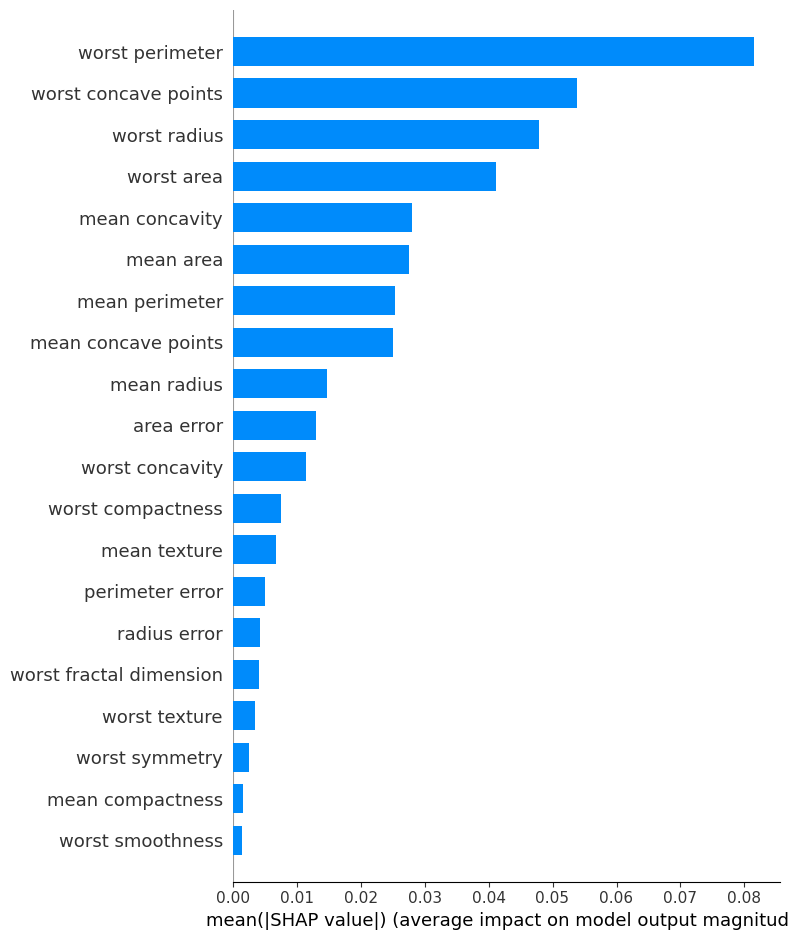

In [62]:
# Use SHAP to explain the predictions of the Random Forest classifier
explainer = shap.Explainer(clf.predict_proba, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values[:, :, 1], X_test, plot_type='bar')

### LIME

Using lime we are able to see the importance of each feature for a single instance, in this case we are analyzing the instance of index 0.
And in this case the model is 19% sure the tumor is malignant and 81% sure the tumor is benign.
With this being said it also shows the most crucial features it used to come to this conclusion.
And as we can see, it agrees with the previous models in concluding worst perimeter and worst concave points as the most important features, it also presents some importance to mean concavity and worst radius 2 features not really agreed on by the other models,

In [64]:
# Use LIME to explain the predictions of the Random Forest classifier
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode='classification', feature_names=X_train.columns, class_names=target_names_original)
X_test_array = X_test.values
i = 0 # Pick the first test instance
exp = explainer.explain_instance(X_test_array[i], clf.predict_proba)
from IPython.core.display import HTML
exp_str = exp.as_html()
exp_str_with_bg = f'<div style="background-color: white;">{exp_str}</div>'
HTML(exp_str_with_bg)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
